# DESaster Application Template
v. 060517

## Required Modules

In [1]:
# System modules
import sys, random, inspect
from datetime import datetime
from IPython.display import display

# Data analysis modules
import pandas as pd
import numpy as np
from scipy.stats import uniform, beta
import random
from ipywidgets import Dropdown


# SimPy modules
import simpy
from simpy import Resource, Container, FilterStore
from simpy.util import start_delayed

# Viz modules
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import Map, FeatureGroup, Marker, LayerControl

### DESaster Modules
desaster_path = "/Users/geomando/Dropbox/github/DESaster"
sys.path.append(desaster_path)
import desaster
from desaster.io import *
from desaster.structures import *
from desaster.financial import *
from desaster.technical import *
from desaster.entities import *
from desaster.policies import *
from desaster.distributions import *

In [42]:
import sys, inspect

# inspect.

def print_classes():
    for name, obj in inspect.getmembers(desaster.entities):
        if inspect.isclass(obj):
            print(name)

print_classes()

Building
Container
Entity
Household
Landlord
Owner
OwnerHousehold
RenterHousehold
SingleFamilyResidential


## Import Households Attribute Data
Input data must be MS Excel .xlsx file with format (column names and sheet names) of ../inputs/desaster_input_data_template.xlsx

In [3]:
scenario_file = '../inputs/desaster_input_data_template.xlsx'

__Create Pandas dataframe of attribute data for all OwnerHouseholds to be modeled in the simulation.__

In [4]:
owners_df = pd.read_excel(scenario_file, sheetname='owners')

__Create Pandas dataframe of attribute data for all RenterHouseholds to be modeled in the simulation.__

In [5]:
renters_df = pd.read_excel(scenario_file, sheetname='renters')

## Setup the Simulation Environment, Define Parameter Distributions, and Populate with Households, Recovery Programs, and Recovery Policies

__Set Simpy simulation environment__

In [6]:
env = simpy.Environment()

__Indicate whether the simulation will keep track of the stories of each entity in the simulation. This can also be set individually for each group of imported entities (e.g., each call to an entities.Entity class or subclass.__

In [7]:
write_story = True

__Define the probability distributions that can be used in the simulation to define various recovery program process event durations.__

In [8]:
# A determistic scalar
scalar_dist = ProbabilityDistribution(dist='scalar', loc=10) 
# A determistic scalar for the repair program (which dynamically changes the distribution parameters)
repair_scalar_dist = ProbabilityDistribution(dist='scalar', loc=10) 
# A uniform distribution; min = loc, max = (loc + scale)
uni_dist = ProbabilityDistribution(dist='uniform', loc=5, scale=10) 
# A beta distribution; parameters define as numpy.stats.beta
beta_dist = ProbabilityDistribution(dist='beta', loc=5, scale=30, shape_a=2.0, shape_b=2.0)
# A weibull distribution; parameters define as numpy.stats.beta
wei_dist = ProbabilityDistribution(dist='weibull', loc=5, scale=10, shape_c=2.0)

# Some distributions to parameterize specific programs
sba_dist = DurationDistributionHomeLoanSBA(dist='scalar', loc=10) 
fema_scalar_dist = ProbabilityDistribution(dist='scalar') 

__Instantiate the recovery program objects that will be used in the simulation. Each recovery program requires
specification of a duration probability distribution (set above). Unlike shown below, the distributions do not have to be the same for each program. Currently all are the same scalars to simplify interpretation and debugging.__

In [9]:
declaration = 30 # Placeholder deterministic scalar that defines number of days before federal disaster declared
sba_deadline = 60 # Typically duration in days after declaration that SBA applications must be submitted

# Instantiate a FEMA Individual Assistance program
fema_ia = HousingAssistanceFEMA(env, staff=100, budget=10000000, duration_distribution=fema_scalar_dist, max_outlay=30000,
                                  deadline=540, declaration_duration=declaration)
# Instantiate a SBA Loan program to use w/ OwnerHouseholds
sba_home_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration_distribution=sba_dist, max_loan = 200000, 
                            min_credit = 600, deadline=sba_deadline, declaration_duration=declaration)
# Instantiate a SBA Loan program to use w/ Landlords (higher maximum for businesses)
sba_biz_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration_distribution=scalar_dist, 
                           max_loan = 2000000, deadline=sba_deadline, declaration_duration=declaration) # SBA max biz loan = $2mil
# Instantiate a private insurance program
insurance = OwnersInsurance(env, staff=100, deductible=0.0, duration_distribution=scalar_dist)
# Instantiate a rapid inspection (tagging) program
inspection = InspectionProgram(env, staff=1000, duration_distribution=scalar_dist)
# Instantiate a detailed engineering assessment program
assessment = EngineeringAssessment(env, staff=1000, duration_distribution=scalar_dist)
# Instantiate a building permit processing program
permitting = PermitProgram(env, staff=1000, duration_distribution=scalar_dist) 
# Instantiate a program to represent private repair contractors
repair = RepairProgram(env, staff=1000, materials=1000000000, duration_distribution=repair_scalar_dist)
# Instantiate a program to represent private demolition contractors
demolition = DemolitionProgram(env, staff=1000, duration_distribution=scalar_dist)

__Instantiate any recovery policies. Policies are custom classes that define different recovery program arrangements, sequences, logic, patience, etc. Currently only one is written Insurance_IA_Loan_Sequential, which very loosely mimics FEMA's required sequencing of funding requests. The policy also provides an example of how to model entity "patience" and process interuption.__

In [10]:
insurance_ia_loan_seq = Insurance_IA_SBA_Sequential(env)
insurance_ia_loan_para = Insurance_IA_SBA_Parallel(env)
insurance_loan_seq = Insurance_SBA_Sequential(env)
insurance_loan_para = Insurance_SBA_Parallel(env)
repair_stock = RepairVacantBuilding(env)

__Create empty Simpy FilterStores to use as housing stocks.__

In [11]:
owned_stock = FilterStore(env)  # To put the residences associated with owners
rented_stock = FilterStore(env) # To put the residences associated with renters
# forsale_stock = FilterStore(env) # To put the homes associated with vacant home sellers
# forrent_stock = FilterStore(env) # To put the homes associated with vacant home landlords

__Create a list of OwnerHousehold objects based on input data. Place each associated residence in the rented housing stock.__

In [12]:
owners = importEntities(env, owners_df, 'OwnerHousehold', owned_stock, write_story)

__Create a list of RenterHousehold objects based on input data. Place each associated residence in the rented housing stock.__

In [13]:
renters = importEntities(env, renters_df, 'RenterHousehold', rented_stock, write_story)

# Specify master processes for Landlords, OwnerHouseholds, and Renter Households
Note: Master processes define custom, case-specific, scenario-based, or user-defined logic for modeled entities. They are not "hard coded" processes or policies in DESaster.

*A listing of arguments for each of the recovery programs and policies to help write master processes.*

In [14]:
def list_args(programs_policies):
    for p in programs_policies:
        print(str(p.__func__)[10:-16], inspect.getfullargspec(p).args) # Useful to determine the arguments for the recovery programs

programs_policies = [fema_ia.process, sba_home_loan.process, sba_biz_loan.process, insurance.process, 
                     inspection.process, assessment.process, permitting.process, repair.process, 
                     demolition.process, insurance_ia_loan_seq.policy, insurance_ia_loan_para.policy, 
                     insurance_loan_seq.policy, insurance_loan_para.policy, repair_stock.policy]

list_args(programs_policies)

HousingAssistanceFEMA.process ['self', 'entity', 'callbacks']
RealPropertyLoanSBA.process ['self', 'entity', 'callbacks']
RealPropertyLoanSBA.process ['self', 'entity', 'callbacks']
OwnersInsurance.process ['self', 'entity', 'callbacks']
InspectionProgram.process ['self', 'structure', 'entity', 'callbacks']
EngineeringAssessment.process ['self', 'structure', 'entity', 'callbacks']
PermitProgram.process ['self', 'structure', 'entity', 'callbacks']
RepairProgram.process ['self', 'structure', 'entity', 'callbacks']
DemolitionProgram.process ['self', 'structure', 'entity', 'callbacks']
Insurance_IA_SBA_Sequential.policy ['self', 'insurance_program', 'fema_program', 'sba_program', 'entity', 'search_patience']
Insurance_IA_SBA_Parallel.policy ['self', 'insurance_program', 'fema_program', 'sba_program', 'entity', 'search_patience']
Insurance_SBA_Sequential.policy ['self', 'insurance_program', 'sba_program', 'entity', 'search_patience']
Insurance_SBA_Parallel.policy ['self', 'insurance_program

__A really basic custom master process as an example of how to create one.__

In [15]:
def basic_process(inspection_program, assessment_program, permit_program, repair_program, entity):
        yield env.process(inspection_program.process(entity.property, entity))
        yield env.process(assessment_program.process(entity.property, entity))
        yield env.process(permit_program.process(entity.property, entity))
        yield env.process(repair_program.process(entity.property, entity))

__A custom master process for Landlords. Landlords are the owners of renters' residences and so are the ones to seek financial assistance for repairs.__

In [16]:
def landlord_process(env, inspection_program, insurance_program, loan_program, 
                 assessment_program, permit_program, demolish_program, repair_program, entity):
    
    money_patience = 100000  # days until give up the search for repair money
    
    # Do inspection
    yield env.process(inspection_program.process(entity.property, entity)) 
    
    # Simulate damaged properties
    if entity.property.damage_state != 'None': 
         
        # If is extensively/completely damaged, evict tenant. Eventually initiate temp/transition shelter etc.
        if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
            entity.evict_tenant()

        # Landlord search for financial assistance using an Insurance_Loan policy. Note two alternate versions are 
        # can be used: a parallel policy or a sequential policy. Uncomment the desired policy approach.
        # yield env.process(insurance_loan_seq.policy(insurance_program, loan_program, entity, money_patience)) # Sequential
        yield env.process(insurance_loan_para.policy(insurance_program, loan_program, entity, money_patience))  # Parallel

        # If landlord gives up looking for recovery funds, evict their tenant
        if entity.gave_up_funding_search != None:
            entity.evict_tenant()
            
            if entity.write_story:
                entity.story.append(
                '{0} decided not to repair their {1}. '.format(
                entity.name, entity.property.occupancy.lower()
                                                                )
                                    )
            return
        
        # If has enough recovery funds, repair; if not, evict tenant.
        if entity.recovery_funds.level >= entity.property.damage_value:
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            
            # Demolish property if > extensive damage
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(repair_program.process(entity.property, entity))
        else:
            if entity.tenant.residence != None:
                entity.evict_tenant()  

__A custom master process for OwnerHouseholds (owner occupiers). Don't do anything if no damage suffered. If residence damage is "Complete", abandon home and look to buy a different one. Otherwise look for financial assistance for repairs. If money for repairs can't be found (patience runs out), look for a new home. If home search patience runs out, simply stop.__

In [17]:
def owner_process(env, inspection_program, insurance_program, fema_program, loan_program, 
                 assessment_program, permit_program, demolish_program, rebuild_program, search_stock, entity):
    
    money_patience = 200000  # days until give up the search for rebuild money
    home_patience = 15000  # days until give up the search for a new home
    
    # Do inspections
    yield env.process(inspection_program.process(entity.property, entity))
    
    # Process damaged properties
    if entity.property.damage_state != 'None':
        
        # Search for financial assistance
        yield env.process(insurance_ia_loan_para.policy(insurance_program, fema_program,
                                                   loan_program, entity, money_patience))

        # If not enough money to repair home or home completely damaged, search for a new home to purchase.
        if (entity.recovery_funds.level < entity.property.damage_value or
                entity.property.damage_state == 'Complete'):

            yield env.process(entity.replace_home(search_stock, scalar_dist, down_payment_pct = 0.10,
                                                  search_patience = home_patience))
            
            if entity.gave_up_home_search == None:
                yield env.process(entity.occupy(duration_distribution = scalar_dist))
            
            return
        # Otherwise repair home.       
        elif entity.recovery_funds.level >= entity.property.damage_value:
            
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(rebuild_program.process(entity.property, entity))    
            yield env.process(entity.occupy(duration_distribution = scalar_dist))     

__A custom master process for RenterHouseholds. For the most part it simply initiates a process for their landlords. If they are evicted by their landlords, the renter will look for a new home. If home search patience runs out, simply stop. Otherwise, occupy home after landlord repairs it.__

In [18]:
def renter_process(env, inspection_program, landlord_insurance, 
                   landlord_loan, assessment_program, permit_program, demolish_program, rebuild_program, 
                   search_stock, entity):
        
    money_patience = 365  # days until give up the search for rebuild money
    home_patience = 550  # days until give up the search for a new home
    
    # Process damaged homes
    if entity.residence.damage_state != 'None':
        # Process landlord property repairs
        yield env.process(landlord_process(env, inspection_program, landlord_insurance, 
                                landlord_loan, assessment_program, permit_program, demolish_program, 
                                rebuild_program, entity.landlord))
   
        # Check to see if renter has a residence, occupy if so.
        if entity.residence != None:
            yield env.process(entity.occupy(duration_distribution = scalar_dist))
        # Otherwise look for a new residence
        else:

            yield env.process(entity.replace_home(search_stock, scalar_dist, search_patience = home_patience))

            if not entity.gave_up_home_search:
                    yield env.process(entity.occupy(duration_distribution = scalar_dist))
        
        # For printing and viz convenience, add the landlord's story to renter's story
        entity.story += entity.landlord.story

__Initiate the master process for each owner to be modeled in the simulation.__

In [19]:
#inspect.getfullargspec(owner_process).args # Useful to determine what arguments are required for the process.

for i in range(len(owners)):
    env.process(owner_process(env, inspection, insurance, fema_ia, sba_home_loan, 
                                    assessment, permitting, demolition, repair,
                                    owned_stock, owners[i]))

__Initiate the master process for each renter to be modeled in the simulation.__

In [20]:
# # #inspect.getfullargspec(renter_process).args # Useful to determine what arguments are required for the process.

for i in range(len(renters)):
    env.process(renter_process(env, inspection, insurance, sba_biz_loan, assessment, permitting, 
                                    demolition, repair, rented_stock, renters[i]))

## Run the simulation

In [21]:
env.run()

# Summarize and visualize simulation outputs

## OwnerHousehold summary statistics

In [22]:
output_summary(owners, 'OwnerHousehold')

8 out of 8 owners suffered damage to their homes.
 3 out of 8 owners rebuilt or repaired their damaged home.
 0 out of 8 owners gave up searching for money.
 1 out of 8 owners searchesd for a new home.
 1 out of 8 owners bought a new home.
 0 out of 8 owners gave up searching for a home.


## Print OwnerHousehold stories

In [23]:
owners[0].story

['Alfred resides at 62 That St. ',
 'Alfred owns and lives in a 1 room mobile home at 62 That St worth $306,900. ',
 "Alfred's mobile home was inspected 10 days after the event and suffered $306,900 of damage (complete). ",
 'Alfred has no hazard insurance. ',
 'Alfred applied for a $200,000 SBA loan 30.0 days after the event.',
 'Alfred requested $30,000 from FEMA 30 days after the event. ',
 'Alfred received $30,000 from FEMA 30 days after the event. ',
 "SBA inspected Alfred's home on day 41.0 after the event. ",
 'Alfred received an initial SBA loan disbursement of $25,000 41.0 days after the event. ',
 'Alfred received a second SBA loan disbursement of $175,000 51.0 days after the event. ',
 'It took Alfred 21 days to exhaust financial assistance options but still does not have enough money to cover repairs ($230,100). ',
 'Alfred started searching for a new mobile home 51 days after the event. ',
 'On day 61, Alfred purchased a mobile home at 100 New Ave with a value of $300,000.

In [24]:
owners[1].story

['Bruce resides at 720 This Rd. ',
 'Bruce owns and lives in a 4 room single family dwelling at 720 This Rd worth $837,000. ',
 "Bruce's single family dwelling was inspected 10 days after the event and suffered $83,700 of damage (moderate). ",
 'Bruce submitted an insurance claim 10 days after the event. ',
 'Bruce received a $83,700 insurance payout 20 days after the event. ',
 'Bruce requested $30,000 from FEMA 30 days after the event. ',
 'Bruce withdrew their application to FEMA 30.0 days after the event because enough recovery funds were found from other sources. ',
 'It took Bruce 20 days to exhaust financial assistance options and now has $83,800 for repairs. ',
 'Bruce received an engineering assessment 40 days after the event. ',
 'Bruce received permit approval 50 days after the event. ',
 "Bruce's single family dwelling was repaired 52 days after the event. ",
 'Bruce occupied the single family dwelling 62 days after the event. ']

In [25]:
owners[2].story

['Selena resides at 1001 Other Ave. ',
 'Selena owns and lives in a 2 room single family dwelling at 1001 Other Ave worth $209,250. ',
 "Selena's single family dwelling was inspected 10 days after the event and suffered $93,535 of damage (extensive). ",
 'Selena has no hazard insurance. ',
 'Selena applied for a $63,535 SBA loan 30.0 days after the event.',
 'Selena requested $30,000 from FEMA 30 days after the event. ',
 'Selena received $30,000 from FEMA 30 days after the event. ',
 "SBA inspected Selena's home on day 41.0 after the event. ",
 'Selena received an initial SBA loan disbursement of $25,000 41.0 days after the event. ',
 'Selena received a second SBA loan disbursement of $38,535 51.0 days after the event. ',
 'It took Selena 21 days to exhaust financial assistance options and now has $93,635 for repairs. ',
 'Selena received an engineering assessment 61 days after the event. ',
 'Selena received permit approval 71 days after the event. ',
 "Selena's single family dwellin

In [26]:
owners[3].story

['Fish resides at 26000 Out There Lane. ',
 'Fish owns and lives in a 3 room single family dwelling at 26000 Out There Lane worth $558,000. ',
 "Fish's single family dwelling was inspected 10 days after the event and suffered $11,160 of damage (slight). ",
 'Fish has no hazard insurance. ',
 'Fish requested $11,160 from FEMA 30 days after the event. ',
 'Fish received $11,160 from FEMA 30 days after the event. ',
 'It took Fish 0 days to exhaust financial assistance options and now has $11,260 for repairs. ',
 'Fish received an engineering assessment 40 days after the event. ',
 'Fish received permit approval 50 days after the event. ',
 "Fish's single family dwelling was repaired 52 days after the event. ",
 'Fish occupied the single family dwelling 62 days after the event. ']

## RenterHousehold summary statistics

In [27]:
output_summary(renters, 'RenterHousehold')

8 out of 8 renters' homes suffered damage.
 4 out of 8 renters' damaged home was rebuilt or repaired.
 4 out of 8 renters' were displaced.
 0 landlords gave up searching for repair money.


## Print RenterHousehold stories

In [28]:
renters[0].story

['Ivy resides at 262 That St. ',
 'Ivy rents and lives in a 1 room mobile home at 262 That St. ',
 'Ivy occupied the mobile home 42 days after the event. ',
 'Alice rents out a 1 bedroom mobile home at 262 That St worth $279,000. ',
 "Alice's mobile home was inspected 10 days after the event and suffered $27,900 of damage (moderate). ",
 'Alice already had enough money to repair ($30,000) and did not seek assistance. ',
 'Alice received an engineering assessment 20 days after the event. ',
 'Alice received permit approval 30 days after the event. ',
 "Alice's mobile home was repaired 32 days after the event. "]

In [29]:
renters[1].story

['Edward resides at 4720 This Rd. ',
 'Edward rents and lives in a 3 room single family dwelling at 4720 This Rd. ',
 'Edward occupied the single family dwelling 42 days after the event. ',
 'Julie rents out a 3 bedroom single family dwelling at 4720 This Rd worth $418,500. ',
 "Julie's single family dwelling was inspected 10 days after the event and suffered $8,370 of damage (slight). ",
 'Julie already had enough money to repair ($30,000) and did not seek assistance. ',
 'Julie received an engineering assessment 20 days after the event. ',
 'Julie received permit approval 30 days after the event. ',
 "Julie's single family dwelling was repaired 32 days after the event. "]

In [30]:
renters[2].story

['Oswald resides at 2301 Other Ave. ',
 'Oswald rents and lives in a 0 room single family dwelling at 2301 Other Ave. ',
 'Oswald was evicted because the single family dwelling had extensive damage. ',
 'Oswald started searching for a new single family dwelling 240 days after the event. ',
 'On day 790, after a 550 day search, Oswald gave up looking for a new home in the local area. ',
 'Gerry rents out a 0 bedroom single family dwelling at 2301 Other Ave worth $139,500. ',
 "Gerry's single family dwelling was inspected 10 days after the event and suffered $62,356 of damage (extensive). ",
 'Gerry submitted an insurance claim 10 days after the event. ',
 'Gerry received a $62,356 insurance payout 20 days after the event. ',
 'It took Gerry 20 days to exhaust financial assistance options and now has $92,356 for repairs. ',
 'Gerry received an engineering assessment 40 days after the event. ',
 'Gerry received permit approval 50 days after the event. ',
 "Gerry's single family dwelling w

In [31]:
renters[3].story

['James resides at 74000 Out There Lane. ',
 'James rents and lives in a 2 room single family dwelling at 74000 Out There Lane. ',
 'James was evicted because the single family dwelling had complete damage. ',
 'James started searching for a new single family dwelling 240 days after the event. ',
 'On day 790, after a 550 day search, James gave up looking for a new home in the local area. ',
 'Sally rents out a 2 bedroom single family dwelling at 74000 Out There Lane worth $558,000. ',
 "Sally's single family dwelling was inspected 10 days after the event and suffered $558,000 of damage (complete). ",
 'Sally submitted an insurance claim 10 days after the event. ',
 'Sally received a $558,000 insurance payout 20 days after the event. ',
 'It took Sally 20 days to exhaust financial assistance options and now has $588,000 for repairs. ',
 'Sally received an engineering assessment 40 days after the event. ',
 'Sally received permit approval 50 days after the event. ',
 "Sally's single fam

In [33]:
df = households_to_df(owners)

outfile = '../outputs/' + str(datetime.now().hour) + str(datetime.now().minute) + str(datetime.now().day) \
                 + str(datetime.now().month) + str(datetime.now().year) + '.csv'

# df.to_csv(outfile)

In [34]:
df.head(3)

,address,area,assessment,assessment_get,assessment_put,assistance_payout,bathrooms,bedrooms,claim_amount,claim_get,...,repair_put,residence,savings,sba_amount,sba_get,sba_put,stock,story,value,write_story
0,62 That St,1100.0,False,None,None,0.0,1.0,1.0,0.0,None,...,None,NaN,100.0,200000.00,51,30,NaN,Alfred resides at 62 That St. Alfred owns and ...,306900.0,True
1,720 This Rd,3000.0,True,40,30,0.0,3.0,4.0,83700.0,20,...,50,NaN,100.0,0.00,None,30,NaN,Bruce resides at 720 This Rd. Bruce owns and l...,837000.0,True
2,1001 Other Ave,750.0,True,61,51,0.0,1.0,2.0,0.0,None,...,81,NaN,100.0,63534.75,51,30,NaN,Selena resides at 1001 Other Ave. Selena owns ...,209250.0,True


In [35]:
event_list=[]


for i in df.columns:
    if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "gave" in i:
        event_list.append(i)

event_df = df[event_list]
event_df = event_df.set_index('name')

__Visualize events experienced by an individual entity.__

In [36]:
names = sorted([f for f in df['name']])

name_chooser = Dropdown(
    options=names
)
display(name_chooser)



Widget Javascript not detected.  It may not be installed or enabled properly.


[<matplotlib.text.Text at 0x111d79ba8>, <matplotlib.text.Text at 0x111d283c8>]

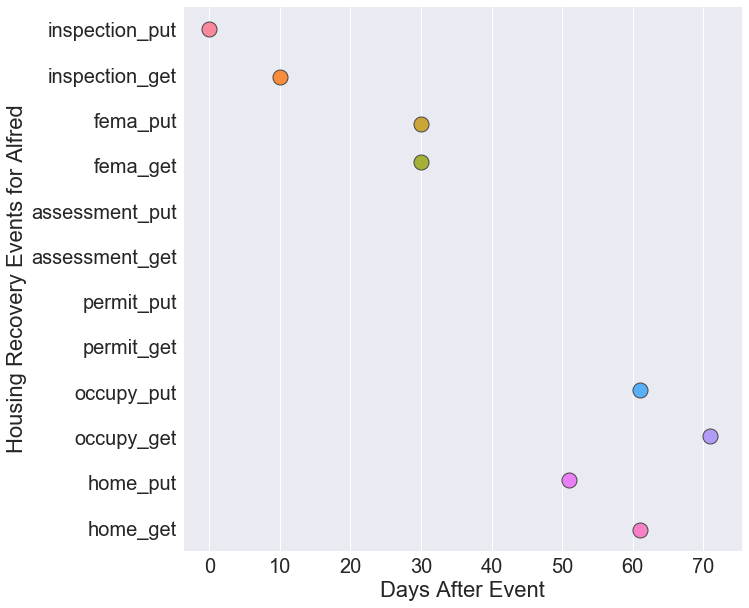

In [37]:
name = name_chooser.value

name_row = df[df['name']==name][['inspection_put',
 'inspection_get',
 'fema_put',
 'fema_get',
 'assessment_put',
 'assessment_get',
 'permit_put',
 'permit_get',
'occupy_put',
'occupy_get',
 'home_put',
 'home_get']]

%matplotlib inline
plt.figure(figsize=(10,10))
sns.set_style(style="whitegrid")
sns.set(font_scale=2)
ax = sns.stripplot(name_row.iloc[0], name_row.columns, jitter=True, size = 15, linewidth=1)
ax.set(xlabel="Days After Event", ylabel="Housing Recovery Events for {0}".format(name))

Map of outputs

In [38]:
map = folium.Map(location=(43.223628, -90.294633), tiles='Stamen Terrain', zoom_start=18)

folium.TileLayer('Stamen Terrain').add_to(map)
folium.TileLayer('OpenStreetMap').add_to(map)

complete_group = FeatureGroup(name='Complete Damage')
extensive_group = FeatureGroup(name='Extensive Damage')
moderate_group = FeatureGroup(name='Moderate Damage')
slight_group = FeatureGroup(name='Slight Damage')
none_group = FeatureGroup(name='No Damage')

for i in df.iterrows():

    if i[1].damage_state_start == 'Complete':
        try:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          popup=i[1].story, icon=folium.Icon("darkred", icon='home')).add_to(complete_group)
        except AttributeError:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          icon=folium.Icon("darkred", icon='home')).add_to(complete_group)
    elif i[1].damage_state_start == 'Extensive':
        try:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          popup=i[1].story, icon=folium.Icon("red", icon='home')).add_to(extensive_group)
        except AttributeError:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          icon=folium.Icon("red", icon='home')).add_to(extensive_group)
    elif i[1].damage_state_start == 'Moderate':
        try:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          popup=i[1].story, icon=folium.Icon("orange", icon='home')).add_to(moderate_group)
        except AttributeError:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          icon=folium.Icon("orange", icon='home')).add_to(moderate_group)
    elif i[1].damage_state_start == 'Slight':
        try:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          popup=i[1].story, icon=folium.Icon("lightgreen", icon='home')).add_to(slight_group)
        except AttributeError:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          icon=folium.Icon("lightgreen", icon='home')).add_to(slight_group)
    else:
        try:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          popup=i[1].story, icon=folium.Icon("green", icon='home')).add_to(none_group)
        except AttributeError:
            folium.Marker(location = [i[1].latitude, i[1].longitude],
                          icon=folium.Icon("green", icon='home')).add_to(none_group)


map.add_child(complete_group)
map.add_child(extensive_group)
map.add_child(moderate_group)
map.add_child(slight_group)
map.add_child(none_group)
map.add_child(folium.map.LayerControl())
map.add_child(plugins.Fullscreen())

map

Plots of outputs

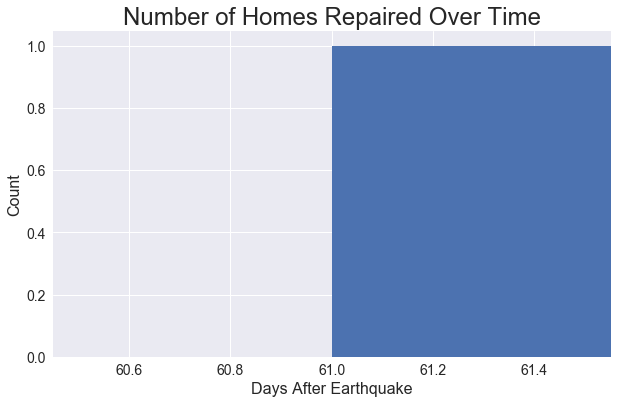

In [39]:
f, ax = plt.subplots(1, figsize=(16, 6))
df["home_get"].plot(kind='hist', bins=10, title='Number of Homes Repaired Over Time', figsize=(10,6), fontsize=14)
plt.xlabel('Days After Earthquake', fontsize=16)
plt.ylabel('Count', fontsize=16)

for container in ax.containers:
              plt.setp(container, width=1)        

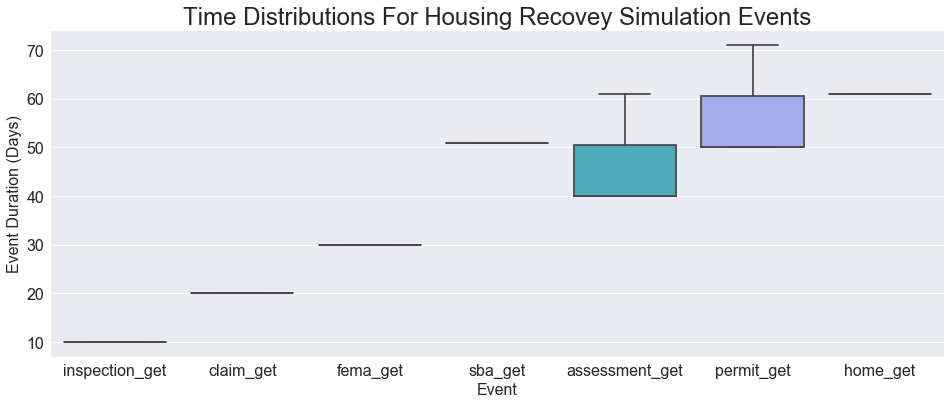

In [40]:
f, ax = plt.subplots(1, figsize=(16, 6))
sns.boxplot(data=df[['inspection_get', 'claim_get', 'fema_get', 'sba_get', 
                      'assessment_get', 'permit_get', 'home_get']], ax=ax)
plt.xlabel('Event', fontsize=16)
plt.ylabel('Event Duration (Days)', fontsize=16)
plt.xticks(fontsize=12)
plt.title('Time Distributions For Housing Recovey Simulation Events')

ax.tick_params(labelsize=16)

In [41]:
# f, ax = plt.subplots(1, figsize=(16, 6))

# order = ['None', 'Slight', 'Moderate','Extensive','Complete']

# df_damage_state = df[['home_get', 'damage_state_start']].groupby('damage_state_start')

# df_damage_state_mean = df_damage_state.mean().ix[order]

# df_damage_state_mean.plot(kind='bar', rot=0, legend=False, ax=ax)

# plt.xlabel('Damage State', fontsize=16)
# plt.ylabel('Days After Earthquake', fontsize=16)
# plt.xticks(fontsize=12)
# plt.title('Mean Time To Repair Home vs. Damage State')

# ax.tick_params(labelsize=16)